# NATURAL LANGUAGE PROCESSING WITH CONVOLUTIONAL NEURAL NETWORKS
# Α Pos Tagger trained on UD treebank

In [ ]:
# First install some extra packages
# ! pip install pyconll
# ! pip install pydot
# ! pip install graphiz

In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
import pyconll, keras, gensim, pickle, os, random, nltk, datetime, warnings, gc, urllib.request, zipfile, collections
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import FastText
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, learning_curve, cross_val_score
from sklearn import preprocessing
from sklearn.metrics.classification import UndefinedMetricWarning

from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, LSTM, Bidirectional, GRU, TimeDistributed, concatenate,\
SpatialDropout1D, Layer, Lambda, BatchNormalization, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import Callback
from keras.models import load_model
from keras.utils import plot_model
from IPython.display import Image 
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

Using TensorFlow backend.


In [2]:
from keras.layers import Flatten, GlobalMaxPooling1D
from keras.layers.merge import add
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D
from keras import backend as K

# Various plot functions

In [3]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [4]:
def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          i=1):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(10, 6))
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

In [5]:
def plot_acc():
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [6]:
def plot_loss():
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Parameters for NNs

In [7]:
MAX_CHAR_LENGTH=3
MAX_SEQUENCE_LENGTH = 70
EMBEDDING_DIM = 300
#VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
EPOCHS = 30

# Load Dataset

In [8]:
UD_ENGLISH_TRAIN = 'en_partut-ud-train.conllu'
UD_ENGLISH_DEV = 'en_partut-ud-dev.conllu'
UD_ENGLISH_TEST = 'en_partut-ud-test.conllu'

In [9]:
def download_files():
    print('Downloading English treebank...')
    urllib.request.urlretrieve('http://archive.aueb.gr:8085/files/en_partut-ud-dev.conllu', 'en_partut-ud-dev.conllu')
    urllib.request.urlretrieve('http://archive.aueb.gr:8085/files/en_partut-ud-test.conllu', 'en_partut-ud-test.conllu')
    urllib.request.urlretrieve('http://archive.aueb.gr:8085/files/en_partut-ud-train.conllu', 'en_partut-ud-train.conllu')
    print('Treebank downloaded.')
    print('Downloading Fasttext pre-trained word embeddings...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip', 'wiki-news-300d-1M.vec.zip')
    print('Pre-trained word embeddings downloaded.')
    print('Extracting zip file...')
    zip_ref = zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r')
    zip_ref.extractall('.')
    zip_ref.close()
    print('Zip file extracted.')

In [10]:
download_files()

Treebank downloaded.
Pre-trained word embeddings downloaded.
Extracting zip file...
Zip file extracted.


# Preprocessing

In [11]:
def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    t=0
    for sentence in data:
        tagged_sentence=[]
        for token in sentence:
            if token.upos and token.form:
                t+=1
                tagged_sentence.append((token.form.lower(), token.upos))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences

Load train, development and test set in the appropriate tagged format, tuple (word, pos-tag)

In [12]:
train_sentences = read_conllu(UD_ENGLISH_TRAIN)
val_sentences = read_conllu(UD_ENGLISH_DEV)
test_sentences = read_conllu(UD_ENGLISH_TEST)

Print some statistics

In [13]:
print("Tagged sentences in train set: ", len(train_sentences))
print("Tagged words in train set:", len([item for sublist in train_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in dev set: ", len(val_sentences))
print("Tagged words in dev set:", len([item for sublist in val_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in test set: ", len(test_sentences))
print("Tagged words in test set:", len([item for sublist in test_sentences for item in sublist]))
print(40*'*')
print("Total sentences in dataset:", len(train_sentences)+len(val_sentences)+len(test_sentences))

Tagged sentences in train set:  1781
Tagged words in train set: 43518
Tagged sentences in dev set:  156
Tagged words in dev set: 2722
Tagged sentences in test set:  153
Tagged words in test set: 3408
****************************************
Total sentences in dataset: 2090


In [14]:
print(train_sentences[0])

[('distribution', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('license', 'NOUN'), ('does', 'AUX'), ('not', 'PART'), ('create', 'VERB'), ('an', 'DET'), ('attorney', 'NOUN'), ('-', 'PUNCT'), ('client', 'NOUN'), ('relationship', 'NOUN'), ('.', 'PUNCT')]


In [15]:
# Some usefull functions
def tag_sequence(sentences):
    return [[t for w, t in sentence] for sentence in sentences]

def text_sequence(sentences):
    return [[w for w, t in sentence] for sentence in sentences]
    #return [[' '.join([w for w, t in sentence])] for sentence in sentences]

def id2word(sentences):
    wordlist = [item for sublist in text_sequence(sentences) for item in sublist]
    id2word = {k:v for k,v in enumerate(wordlist)}
    return id2word

def untag(tagged_sentence):
    return [w for w, _ in tagged_sentence]

def untag_pos(tagged_sentence):
    return [t for _, t in tagged_sentence]

def build_vocab(sentences):
    vocab =set()
    for sentence in sentences:
        for word in untag(sentence):
            vocab.add(word)
    return sorted(list(vocab))

In [16]:
# Function to convert terms to ids
def numberize(sentences):
    X = []
    Y = []
    u = set() #to keep unkown words
    for sentence in sentences:
        tempX = []
        for word in untag(sentence):
            if word in word2int:
                tempX.append(word2int[word])
            else:
                tempX.append(word2int['-UNK-'])
                u.add(word)
        X.append(tempX)

    for sentence in sentences:
        tempY = []
        for tag in untag_pos(sentence):
            try:
                tempY.append(tag2int[tag])
            except:
                tempY.append(0)                
        Y.append(tempY)
    return X, Y, u

In [17]:
text_sequence(train_sentences)[0:2]

[['distribution',
  'of',
  'this',
  'license',
  'does',
  'not',
  'create',
  'an',
  'attorney',
  '-',
  'client',
  'relationship',
  '.'],
 ['creative',
  'commons',
  'provides',
  'this',
  'information',
  'on',
  'an',
  '"',
  'as',
  '-',
  'is',
  '"',
  'basis',
  '.']]

In [18]:
tag_sequence(train_sentences)[0:2]

[['NOUN',
  'ADP',
  'DET',
  'NOUN',
  'AUX',
  'PART',
  'VERB',
  'DET',
  'NOUN',
  'PUNCT',
  'NOUN',
  'NOUN',
  'PUNCT'],
 ['PROPN',
  'PROPN',
  'VERB',
  'DET',
  'NOUN',
  'ADP',
  'DET',
  'PUNCT',
  'ADP',
  'PUNCT',
  'VERB',
  'PUNCT',
  'NOUN',
  'PUNCT']]

## Build dictionaries with word and tag vocabularies

In [19]:
words = build_vocab(train_sentences+val_sentences+test_sentences)

In [20]:
y_train = [item for sublist in train_sentences for _, item in sublist]
y_test = [item for sublist in test_sentences for _, item in sublist]

In [21]:
len(y_train), len(y_test)

(43518, 3408)

In [22]:
test_tags = sorted(set(y_test))

In [23]:
list(test_tags)

['ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'VERB',
 'X']

In [24]:
tags = set(y_train)
print('VOCABULARY SIZE: ', len(words))
print('TOTAL TAGS: ', len(tags))

VOCABULARY SIZE:  6849
TOTAL TAGS:  17


In [25]:
word2int = {}
int2word = {}

for i, word in enumerate(words):
    word2int[word] = i+2 #We keep indexes 0, 1 for -PAD-, -UNK- terms
    int2word[i+2] = word

In [26]:
# Special characters for the words
word2int['-PAD-'] = 0
int2word[0] = '-PAD-'
word2int['-UNK-'] = 1
int2word[1] = '-UNK-'

In [27]:
word2int['-UNK-']

1

In [28]:
int2word[0]

'-PAD-'

In [29]:
tag2int = {}
int2tag = {}

for i, tag in enumerate(sorted(tags)):
    tag2int[tag] = i+1
    int2tag[i+1] = tag

In [30]:
# Special character for the tags
tag2int['-PAD-'] = 0
int2tag[0] = '-PAD-'

In [31]:
n_tags = len(tag2int)
print('Total words:', len(word2int))
print('Total tags:', n_tags)

Total words: 6851
Total tags: 18


## Load pre-trained word embeddings

We use fasttext wiki-news vectors to build a dictionary with word as key and its vector as value:

In [32]:
# Be patience, needs some time...
embs_path = 'wiki-news-300d-1M.vec'
embeddings = KeyedVectors.load_word2vec_format(embs_path, binary=False)
print('Vectors loaded')
print('Shape of word embeddings:', embeddings.vectors.shape)

Vectors loaded
Shape of word embeddings: (999994, 300)


Let see the 10 most common terms:

In [33]:
w2v = dict()
for item in embeddings.vocab:
    w2v[item]=embeddings.vocab[item].count

In [34]:
dict(sorted(w2v.items(), key=lambda x: x[1],reverse=True)[:10])

{',': 999994,
 'the': 999993,
 '.': 999992,
 'and': 999991,
 'of': 999990,
 'to': 999989,
 'in': 999988,
 'a': 999987,
 '"': 999986,
 ':': 999985}

## Build the embedding matrix

In [35]:
k=0
unk_words=[]
np.random.seed(3) # For reproducibility 
embedding_matrix = np.random.uniform(-0.25, 0.25, size=(len(word2int), EMBEDDING_DIM))
for word, i in word2int.items():
    try:
        embedding_matrix[i] = embeddings[word]
    except:
        unk_words.append(word)
        k += 1
        pass

print('Embedding matrix shape:', embedding_matrix.shape)
print('Words not found in embeddings:', k)

Embedding matrix shape: (6851, 300)
Words not found in embeddings: 254


Let see some of the unknown words and the vector of one of them:

In [36]:
(unk_words)[:10]

['-20º',
 '-40°',
 '829229',
 'a5-0104',
 'a5-0108',
 'abrantès',
 'addenbrooke',
 'ahab',
 'amiens',
 'andronicus']

In [37]:
embedding_matrix[word2int['andronicus']]

array([ 0.00923226,  0.11607097,  0.00914912, -0.00836662,  0.08073582,
       -0.21712801, -0.14776677,  0.08965423, -0.22948775, -0.07954487,
       -0.08859033,  0.03349426,  0.09446749,  0.12586121,  0.00556686,
        0.22594629, -0.13516709,  0.12981253,  0.14026154, -0.17321149,
        0.02756873, -0.13140871,  0.2202786 ,  0.16993988, -0.07141561,
       -0.20325514, -0.19637081,  0.00870133,  0.13582578,  0.14133284,
       -0.1673808 ,  0.03942784, -0.0512051 ,  0.11634851, -0.057533  ,
        0.20721876, -0.18037114,  0.10296286,  0.09142621,  0.219715  ,
        0.08764978,  0.11955814,  0.08928101, -0.0287457 ,  0.18901752,
        0.13876672,  0.0594898 , -0.17407128,  0.09890492, -0.23873098,
       -0.01178332,  0.12421617, -0.1990536 , -0.04828809,  0.09771004,
        0.09763153,  0.20496411,  0.08204624, -0.04679813, -0.15983424,
       -0.08415568, -0.17234804,  0.04943166,  0.03176038,  0.19489024,
        0.0892862 , -0.08931634, -0.20678338, -0.08619215, -0.13

# Baseline tagger

Train and evaluate a Baseline Unigram tagger

In [38]:
default_tagger = nltk.DefaultTagger('NN')
unigram_tagger = nltk.UnigramTagger(train_sentences+val_sentences, backoff=default_tagger)

In [39]:
y_train = [item for sublist in tag_sequence(train_sentences+val_sentences) for item in sublist]
y_test = [item for sublist in tag_sequence(test_sentences) for item in sublist]
classes = sorted(list(set(y_train)))

In [40]:
def tag_list(tagged_sents):
    return [tag for sent in tagged_sents for (word, tag) in sent]
def apply_tagger(tagger, corpus):
    return [tagger.tag(nltk.tag.untag(sent)) for sent in corpus]

In [41]:
y_pred = tag_list(apply_tagger(unigram_tagger, test_sentences))
print("Accuracy: {0:.4f}".format(unigram_tagger.evaluate(test_sentences)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_test, y_pred, average='macro')))

Accuracy: 0.8600
f1-macro score: 0.8261


In [42]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

         ADJ     0.8788    0.7768    0.8246       224
         ADP     0.9452    0.8832    0.9131       488
         ADV     0.9074    0.7481    0.8201       131
         AUX     0.9286    1.0000    0.9630       234
       CCONJ     1.0000    0.9896    0.9948        96
         DET     0.9661    0.9749    0.9705       439
        INTJ     1.0000    1.0000    1.0000         2
          NN     0.0000    0.0000    0.0000         0
        NOUN     0.9549    0.8154    0.8797       753
         NUM     0.9649    0.9016    0.9322        61
        PART     0.5323    1.0000    0.6947        66
        PRON     0.9310    0.7642    0.8394       106
       PROPN     0.8676    0.6556    0.7468        90
       PUNCT     1.0000    1.0000    1.0000       339
       SCONJ     0.6863    0.6863    0.6863        51
        VERB     0.9316    0.6687    0.7786       326
           X     1.0000    1.0000    1.0000         2

   micro avg     0.8600   

See what errors the Baseline tagger makes:

In [43]:
def check_tagger(tagged_sentence):
    note = ''
    for tup in list(zip(unigram_tagger.tag(untag(tagged_sentence)),untag_pos(tagged_sentence))):
        if tup[0][1]!=tup[1]: note='<<--- Error!'
        print(tup[0], tup[1], note)
        note=''

In [44]:
check_tagger(test_sentences[1])

('any', 'DET') DET 
('use', 'NOUN') NOUN 
('of', 'ADP') ADP 
('the', 'DET') DET 
('work', 'NOUN') NOUN 
('other', 'ADJ') ADJ 
('than', 'ADP') SCONJ <<--- Error!
('as', 'ADP') ADP 
('authorized', 'NN') VERB <<--- Error!
('under', 'ADP') ADP 
('this', 'DET') DET 
('license', 'NOUN') NOUN 
('or', 'CCONJ') CCONJ 
('copyright', 'NOUN') NOUN 
('law', 'NOUN') NOUN 
('is', 'AUX') AUX 
('prohibited', 'VERB') VERB 
('.', 'PUNCT') PUNCT 


It makes some mistakes!

In [45]:
cnf_matrix = confusion_matrix(y_test, y_pred)
name='Baseline'

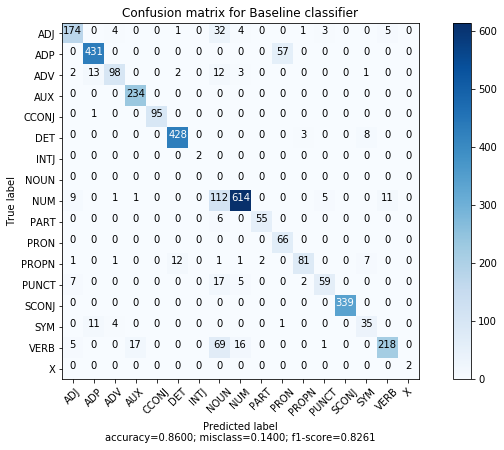

In [46]:
plot_confusion_matrix(f1_score(y_test, y_pred, average='macro'), cnf_matrix, target_names=classes, title='Confusion matrix for '+name+' classifier', normalize=False)

=======================================================================================================

# Special preprocessing for NNs

### This is a very importand step for the whole process! So be careful, to rerun this step in case you change one of the following parameters:
- MAX_SEQUENCE_LENGTH
- BATCH_SIZE

In [47]:
train_sentences = read_conllu(UD_ENGLISH_TRAIN)
val_sentences = read_conllu(UD_ENGLISH_DEV)
test_sentences = read_conllu(UD_ENGLISH_TEST)

Lets examine the train set sentences distribution:

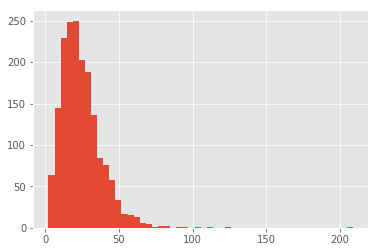

In [48]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in train_sentences], bins=50)
plt.show()

In [49]:
print('Max sentence length:',len(max(train_sentences+val_sentences, key=len)))

Max sentence length: 209


To improve speed we will use a MAX_SEQUENCE_LENGTH shorter than the max lengthed sentence. To avoid truncating sequences during padding we split our sentences to MAX_SEQUENCE_LENGTH and so the number of samples increases accordingly. For example, a sentence with length 120 splits in 2 sentences: 150=70+70+10

In [50]:
def  split(sentences, max):
    new=[]
    for data in sentences:
        new.append(([data[x:x+max] for x in range(0, len(data), max)]))
    new = [val for sublist in new for val in sublist]
    return new

In [51]:
train_sentences = split(train_sentences, MAX_SEQUENCE_LENGTH)
val_sentences = split(val_sentences, MAX_SEQUENCE_LENGTH)
test_sentences = split(test_sentences, MAX_SEQUENCE_LENGTH)

In [52]:
len(max(train_sentences+val_sentences, key=len))

70

For ELMo to work correctly, the **number of samples must be divisible by the batch_size**. So here we pad the samples until their number becomes divisible by the batch_size:

In [53]:
train_sentences = train_sentences+val_sentences

In [54]:
print('Number of samples before sample padding:',len(train_sentences))

Number of samples before sample padding: 1951


In [55]:
def elmo_pad(sentences):
    if len(sentences) % BATCH_SIZE !=0:
        pad_len = ((len(sentences)//BATCH_SIZE)+1)*BATCH_SIZE-len(sentences)
        return sentences.extend([[('-PAD-','-PAD-')]]*pad_len)


In [56]:
elmo_pad(train_sentences)
elmo_pad(test_sentences)
#elmo_pad(val_sentences)

Check the samples padding:

In [57]:
print('Number of samples after sample padding:',len(train_sentences))

Number of samples after sample padding: 1952


In [58]:
train_sentences[-5:]

[[('in', 'ADP'),
  ('shakespeare', 'PROPN'),
  ("'s", 'PART'),
  ('day', 'NOUN'),
  (',', 'PUNCT'),
  ('english', 'ADJ'),
  ('grammar', 'NOUN'),
  (',', 'PUNCT'),
  ('spelling', 'NOUN'),
  ('and', 'CCONJ'),
  ('pronunciation', 'NOUN'),
  ('were', 'AUX'),
  ('less', 'ADV'),
  ('standardised', 'VERB'),
  ('than', 'ADP'),
  ('they', 'PRON'),
  ('are', 'VERB'),
  ('now', 'ADV'),
  (',', 'PUNCT'),
  ('and', 'CCONJ'),
  ('his', 'DET'),
  ('use', 'NOUN'),
  ('of', 'ADP'),
  ('language', 'NOUN'),
  ('helped', 'VERB'),
  ('shape', 'VERB'),
  ('modern', 'ADJ'),
  ('english', 'ADJ'),
  ('.', 'PUNCT')],
 [('in', 'ADP'),
  ('the', 'DET'),
  ('1950', 'NUM'),
  ('s', 'X'),
  (',', 'PUNCT'),
  ('a', 'DET'),
  ('wave', 'NOUN'),
  ('of', 'ADP'),
  ('new', 'ADJ'),
  ('critical', 'ADJ'),
  ('approaches', 'NOUN'),
  ('replaced', 'VERB'),
  ('modernism', 'NOUN'),
  ('and', 'CCONJ'),
  ('paved', 'VERB'),
  ('the', 'DET'),
  ('way', 'NOUN'),
  ('for', 'ADV'),
  ('"', 'PUNCT'),
  ('post', 'NOUN'),
  ('-', 'PUN

## Map and then pad the sentences to sequences of numbers (for terms and also for tags) 

In [59]:
def transform(sentences):
    X, y, unk = numberize(sentences)
    print('sample X_train_numberised: ', X[0])
    print('sample y_train_numberised: ', y[0])
    print('Number of numberized sentences:', len(X))
    print('Number of unknown words:', len(unk))
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    y = pad_sequences(y, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    y = to_categorical(y, num_classes=n_tags)   
    return X, y

In [60]:
X_train, y_train = transform(train_sentences)

sample X_train_numberised:  [1949, 4255, 6227, 3638, 1965, 4186, 1587, 527, 702, 16, 1218, 5191, 19]
sample y_train_numberised:  [8, 2, 6, 8, 4, 10, 16, 6, 8, 13, 8, 8, 13]
Number of numberized sentences: 1952
Number of unknown words: 0


In [61]:
X_test, y_test = transform(test_sentences)

sample X_train_numberised:  [707, 16, 5635, 153, 19]
sample y_train_numberised:  [8, 13, 12, 9, 13]
Number of numberized sentences: 160
Number of unknown words: 0


See a padded numberized sample:

In [62]:
X_train[0]

array([1949, 4255, 6227, 3638, 1965, 4186, 1587,  527,  702,   16, 1218,
       5191,   19,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

In [63]:
y_train[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [64]:
print('Training samples have shape {} and training labels {}'.format(X_train.shape,y_train.shape))
print('Testing samples have shape {} and testing labels {}'.format(X_test.shape,y_test.shape))
#print('Validation samples have shape {} and validation labels {}'.format(X_val.shape,y_val.shape))
print('Word vectors have shape', embeddings.vectors.shape)

Training samples have shape (1952, 70) and training labels (1952, 70, 18)
Testing samples have shape (160, 70) and testing labels (160, 70, 18)
Word vectors have shape (999994, 300)


 # ==============================================================

# 1. CNN with pre-trained word embeddings

## Model building

In [65]:
 def accuracy_masked_class(to_ignore=0):
    def accuracy_masked(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
 
        ignore_mask = K.cast(K.not_equal(y_true_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return accuracy_masked

In [66]:
def define_model(length, filters, vocab_size):
    seed = 0
    
    np.random.seed(seed)
    inputs = Input(shape=(length, ), dtype='int32')
    np.random.seed(seed)
    embedding = Embedding(input_dim=len(word2int),
                  output_dim=EMBEDDING_DIM,
                  weights=[embedding_matrix],
                  input_length=length,
                  trainable=True,
                  mask_zero=False
                 )(inputs)
    
 
    # channel 1
    np.random.seed(seed)
    channel_1 = Conv1D(filters=filters, kernel_size=2, padding='same')(embedding)
    #np.random.seed(seed)
    #channel_1 = add([embedding, channel_1])
    np.random.seed(seed)
    channel_1_2 = Conv1D(filters=filters, kernel_size=2, padding='same')(channel_1)
    #channel_1_3 = Conv1D(filters=filters, kernel_size=2, padding='same')(channel_1_2)
    np.random.seed(seed)
    channel_1 = add([channel_1, channel_1_2])
    np.random.seed(seed)
    channel_1 = Dropout(0.5)(channel_1) 

    # channel 2
    np.random.seed(seed)
    channel_2 = Conv1D(filters=filters, kernel_size=3, padding='same')(embedding)
    np.random.seed(seed)
    #channel_2 = add([embedding, channel_2])
    #np.random.seed(seed)
    channel_2_2 = Conv1D(filters=filters, kernel_size=3, padding='same')(channel_2)
    #channel_2_3 = Conv1D(filters=filters, kernel_size=3, padding='same')(channel_2_2)
    np.random.seed(seed)
    channel_2 = add([channel_2, channel_2_2])
    np.random.seed(seed)
    channel_2 = Dropout(0.5)(channel_2)  

    # channel 3
    np.random.seed(seed)
    channel_3 = Conv1D(filters=filters, kernel_size=4, padding='same')(embedding)
    np.random.seed(seed)
    #channel_3 = add([embedding, channel_3])
    #np.random.seed(seed)
    channel_3_2 = Conv1D(filters=filters, kernel_size=4, padding='same')(channel_3)
    #channe_3_3 = Conv1D(filters=filters, kernel_size=4, padding='same')(channel_3_2)
    np.random.seed(seed)
    channel_3 = add([channel_3, channel_3_2])
    np.random.seed(seed)
    channel_3 = Dropout(0.5)(channel_3) 

    np.random.seed(seed)    
    merged = concatenate([channel_1, channel_2, channel_3])
    np.random.seed(seed)    
    #merged = Dropout(0.2)(merged)
    
    np.random.seed(seed)
    output = Dense(n_tags, activation='softmax')(merged)  # softmax output layer   
    np.random.seed(seed)
    model = Model(inputs=inputs, outputs=output)
    np.random.seed(seed)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', accuracy_masked_class(0)])
    print(model.summary())
    return model

In [67]:
model = define_model(length=MAX_SEQUENCE_LENGTH, filters=100, vocab_size=len(word2int))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 70, 300)      2055300     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 70, 100)      60100       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (Conv1D)    

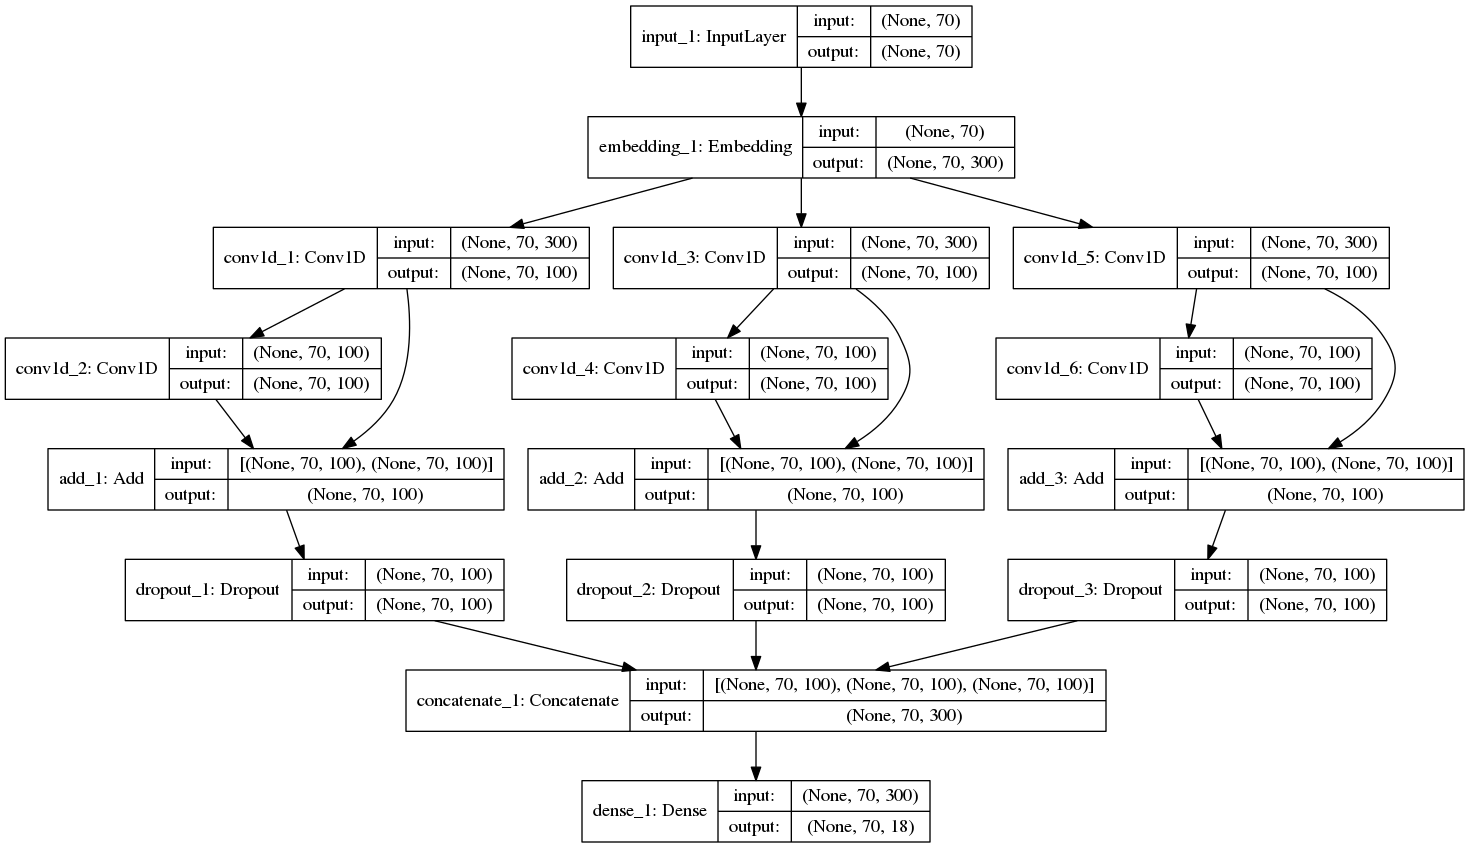

In [68]:
plot_model(model, to_file='model.png', show_shapes=True)
Image('model.png')

## Model training

In [69]:
seed = 0
np.random.seed(seed)
t_ini = datetime.datetime.now()

cp = ModelCheckpoint(filepath="cnn_w2v_tagger.h5",
                     monitor='val_accuracy_masked',
                     save_best_only=True,
                     verbose=1)

early_stopping = EarlyStopping(monitor = 'val_accuracy_masked', patience = 5)


history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,          
                    validation_data=(X_test, y_test),
                    verbose=1,
                    callbacks=[cp, early_stopping])

t_fin = datetime.datetime.now()
print('Training completed in {} seconds'.format((t_fin - t_ini).total_seconds()))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1952 samples, validate on 160 samples
Epoch 1/30
1952/1952 [==============================] - 2s 1ms/step - loss: 0.4719 - acc: 0.8689 - accuracy_masked: 0.6391 - val_loss: 0.1013 - val_acc: 0.9750 - val_accuracy_masked: 0.9163

Epoch 00001: val_accuracy_masked improved from -inf to 0.91629, saving model to cnn_w2v_tagger.h5
Epoch 2/30
1952/1952 [==============================] - 0s 172us/step - loss: 0.0817 - acc: 0.9790 - accuracy_masked: 0.9379 - val_loss: 0.0532 - val_acc: 0.9871 - val_accuracy_masked: 0.9559

Epoch 00002: val_accuracy_masked improved from 0.91629 to 0.95587, saving model to cnn_w2v_tagger.h5
Epoch 3/30
1952/1952 [==============================] - 0s 148us/step - loss: 0.0421 - acc: 0.9885 - accuracy_masked: 0.9660 - val_loss: 0.0498 - val_acc: 0.9883 - val_accuracy_masked: 0.9601

Epoch 00003: val_accuracy_masked improved from 0.95

## Classification report

In [70]:
from keras.models import load_model
model = load_model('cnn_w2v_tagger.h5', custom_objects={'accuracy_masked': accuracy_masked_class()})

In [71]:
y_pred = model.predict(X_test, verbose=1).argmax(-1)
y_true = y_test.argmax(-1)

160/160 [==============================] - 0s 603us/step


In [72]:
y_pred[0]

array([ 8, 13, 12,  9, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0])

In [73]:
y_true[0]

array([ 8, 13, 12,  9, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0])

In [74]:
# Function to convert label ids to labels and use them for sklearn's reports
def y2label(zipped, mask=0):
    out_true = []
    out_pred = []
    for zip_i in zipped:
        a, b = tuple(zip_i)
        if a != mask: #Exclude -PAD- term
            out_true.append(int2tag[a])
            out_pred.append(int2tag[b])
    return out_true, out_pred

In [75]:
y_zipped = zip(y_true.flat, y_pred.flat)
y_true, y_pred = y2label(y_zipped)

In [76]:
len(y_true), len(y_pred)

(3408, 3408)

In [77]:
name='CNN-Word embeddings model'
print('\n--------- Result of {} -------\n'.format(name))
print(classification_report(y_true, y_pred, digits=4))


--------- Result of CNN-Word embeddings model -------

              precision    recall  f1-score   support

         ADJ     0.8884    0.8884    0.8884       224
         ADP     0.9639    0.9857    0.9747       488
         ADV     0.9487    0.8473    0.8952       131
         AUX     0.9915    1.0000    0.9957       234
       CCONJ     1.0000    0.9896    0.9948        96
         DET     0.9977    0.9954    0.9966       439
        INTJ     1.0000    1.0000    1.0000         2
        NOUN     0.9671    0.9748    0.9709       753
         NUM     0.9836    0.9836    0.9836        61
        PART     0.9155    0.9848    0.9489        66
        PRON     0.9615    0.9434    0.9524       106
       PROPN     0.8953    0.8556    0.8750        90
       PUNCT     1.0000    1.0000    1.0000       339
       SCONJ     0.9302    0.7843    0.8511        51
        VERB     0.9398    0.9571    0.9483       326
           X     1.0000    1.0000    1.0000         2

   micro avg     0.9648 

In [78]:
print("Accuracy: {0:.4f}".format(accuracy_score(y_true, y_pred)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_true, y_pred, average='macro')))

Accuracy: 0.9648
f1-macro score: 0.9547


## Confusion matrix

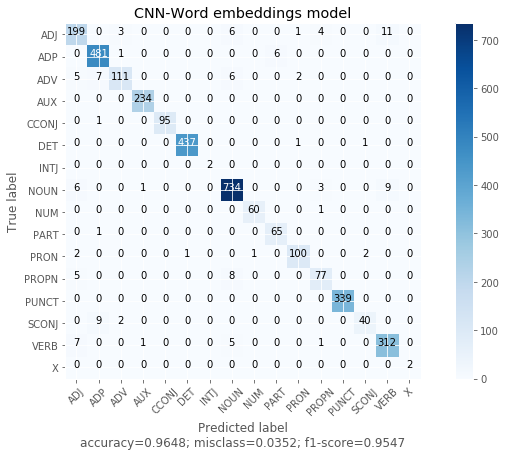

In [79]:
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(f1_score(y_true, y_pred, average='macro'), cnf_matrix, target_names=test_tags, title=name, normalize=False)

## Make a prediction for a test sample:

In [80]:
y_pred = model.predict(X_test).argmax(-1)
y_true = y_test.argmax(-1)

def make_prediction(i=10):
    note = ''
    sent = []
    print("{:15} ({:5}): {}".format("Word", "True", "Predicted"))
    print(35*'-')
    for w, true, pred in zip(X_test[i], y_true[i], y_pred[i]):
        if w!=0:
            if int2tag[true] != int2tag[pred]: note='<<--- Error!'
            print("{:15} ({:5}): {:5} {:5}".format(int2word[w], int2tag[true], int2tag[pred], note))
            note=''

In [81]:
make_prediction(i=1)

Word            (True ): Predicted
-----------------------------------
any             (DET  ): DET        
use             (NOUN ): NOUN       
of              (ADP  ): ADP        
the             (DET  ): DET        
work            (NOUN ): NOUN       
other           (ADJ  ): ADJ        
than            (SCONJ): ADP   <<--- Error!
as              (ADP  ): ADP        
authorized      (VERB ): VERB       
under           (ADP  ): ADP        
this            (DET  ): DET        
license         (NOUN ): NOUN       
or              (CCONJ): CCONJ      
copyright       (NOUN ): NOUN       
law             (NOUN ): NOUN       
is              (AUX  ): AUX        
prohibited      (VERB ): VERB       
.               (PUNCT): PUNCT      


## Tag an unknown sentence

Lets try the predicting power of our trained tagger:

In [82]:
sentence = nltk.word_tokenize('Word embeddings is a dense representation of words and their relative meanings.'.lower())

In [83]:
tokenized_sentence = []
unk = []
i=0
for word in sentence:
    if word in words:
        tokenized_sentence.append(word2int[word])
    else:
        tokenized_sentence.append(word2int['-UNK-'])
        i += 1
        unk.append(word)

#tokenized_sentence = [tokenized_sentence]
padded_tokenized_sentence = pad_sequences([tokenized_sentence], maxlen=MAX_SEQUENCE_LENGTH)

#print("{:15} ({:5}): {:5} {:5}".format(int2word[w], int2tag[true], int2tag[pred], note))

print('The sentence is:', sentence)
print('The tokenized sentence is:', tokenized_sentence)
print('The padded tokenized sentence is:', padded_tokenized_sentence)
print("There are {:} unknown words in sentence: {:}".format(i,(unk)))

The sentence is: ['word', 'embeddings', 'is', 'a', 'dense', 'representation', 'of', 'words', 'and', 'their', 'relative', 'meanings', '.']
The tokenized sentence is: [6784, 1, 3392, 267, 1, 5255, 4255, 6787, 540, 6203, 5193, 1, 19]
The padded tokenized sentence is: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0 6784    1 3392  267    1 5255 4255 6787  540 6203 5193    1   19]]
There are 3 unknown words in sentence: ['embeddings', 'dense', 'meanings']


In [84]:
predictions = model.predict(padded_tokenized_sentence)

print("\n{:25}| {:15}: {:15}".format("Word in embedding layer", 'Initial word', "Predicted POS-tag"))
print(61*'-')
k = 0
for i, pred in enumerate(predictions[0]):
    try:
        if padded_tokenized_sentence[0][i]!=0:
            #print(i)
            #print(int2word[padded_tokenized_sentence[0][i]], ' : ', int2tag[np.argmax(pred)])
            print("{:25}| {:15}: {:5}".format(int2word[padded_tokenized_sentence[0][i]], sentence[k], int2tag[np.argmax(pred)]))
            k+=1
    except:
        pass


Word in embedding layer  | Initial word   : Predicted POS-tag
-------------------------------------------------------------
word                     | word           : -PAD-
-UNK-                    | embeddings     : PROPN
is                       | is             : AUX  
a                        | a              : DET  
-UNK-                    | dense          : ADJ  
representation           | representation : NOUN 
of                       | of             : ADP  
words                    | words          : NOUN 
and                      | and            : CCONJ
their                    | their          : DET  
relative                 | relative       : ADJ  
-UNK-                    | meanings       : NOUN 
.                        | .              : PUNCT


## Frequent types of mistakes

In [85]:
def find_errors(X,y):
    error_counter = collections.Counter()
    support = 0
    y_pred = model.predict(X).argmax(-1)
    y_true = y_test.argmax(-1)
    for i in range(X.shape[0]):
        for w, true, pred in zip(X[i], y_true[i], y_pred[i]):
            if w!=0:
                support +=1
                if true != pred:
                    word = int2word[w]
                    error_counter[word] += 1
    return error_counter, support

In [86]:
errors, support = find_errors(X_test, y_test)
print('Total errors/Total words: {}/{} | Accuracy: {:.4}\n'.format(sum(errors.values()), support, 1-sum(errors.values())/support))
print('Most common errors:', errors.most_common(20))

Total errors/Total words: 120/3408 | Accuracy: 0.9648

Most common errors: [('as', 9), ('to', 8), ('appointed', 5), ('that', 3), ('part', 3), ('justice', 3), ('general', 3), ('contracting', 2), ('thereto', 2), ('longer', 2), ('base', 2), ('than', 1), ('express', 1), ('merchantibility', 1), ('noninfringement', 1), ('discoverable', 1), ('transit', 1), ('is', 1), ('though', 1), ('cause', 1)]


## Learning curves

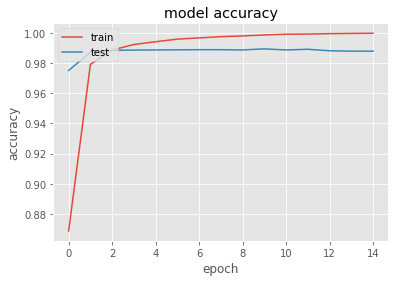

In [87]:
plot_acc()

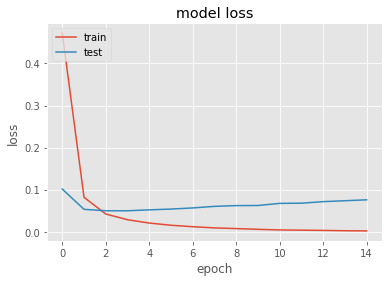

In [88]:
plot_loss()

 # ==============================================================

# 2. CNN with pre-trained Word embeddings enhanced with CNN Character embeddings

In [89]:
chars = set([char for w in words for char in w])
n_chars = len(chars)
print(sorted(chars))

['!', '"', '$', '%', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '°', '·', 'º', 'á', 'â', 'ä', 'ç', 'è', 'é', 'ë', 'í', 'î', 'ï', 'ó', 'ô', 'œ', '–', '—', '‘', '’']


In [90]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx['-UNK-'] = 1
char2idx['-PAD-'] = 0

## Character encoder

In [91]:
# This is a forward character encoder
def char_numberize_forward(sentences, max_len, max_len_char):
    X_char = []
    for sentence in sentences:
        sent_seq = []
        for i in range(max_len):
            word_seq = []
            for j in range(max_len_char):
                try:
                    word_seq.append(char2idx[sentence[i][0][j]])                    
                except:
                    word_seq.append(char2idx['-PAD-'])
            sent_seq.append(word_seq)
        X_char.append(np.array(sent_seq))
    return np.array(X_char)

In [92]:
# This is a backward character encoder
def char_numberize_backward(sentences, max_len, max_len_char):
    X_char = []
    for sentence in sentences:
        sent_seq = []
        for i in range(max_len):
            word_seq = []
            for j in range(max_len_char):
                try:
                    word_seq.append(char2idx[sentence[i][0][-1-j]])                    
                except:
                    word_seq.append(char2idx['-PAD-'])
            sent_seq.append(list(reversed(word_seq)))
        X_char.append(np.array(sent_seq))
    return np.array(X_char)

## Test our character encoder

In [93]:
train_sentences[0:1]

[[('distribution', 'NOUN'),
  ('of', 'ADP'),
  ('this', 'DET'),
  ('license', 'NOUN'),
  ('does', 'AUX'),
  ('not', 'PART'),
  ('create', 'VERB'),
  ('an', 'DET'),
  ('attorney', 'NOUN'),
  ('-', 'PUNCT'),
  ('client', 'NOUN'),
  ('relationship', 'NOUN'),
  ('.', 'PUNCT')]]

### Forward encoder

In [94]:
char_numberize_forward(train_sentences[0:1], max_len=15, max_len_char=10)

array([[[16, 18, 24, 70, 15, 18, 42, 54, 70, 18],
        [43, 32,  0,  0,  0,  0,  0,  0,  0,  0],
        [70, 51, 18, 24,  0,  0,  0,  0,  0,  0],
        [69, 18, 26,  3, 58, 24,  3,  0,  0,  0],
        [16, 43,  3, 24,  0,  0,  0,  0,  0,  0],
        [58, 43, 70,  0,  0,  0,  0,  0,  0,  0],
        [26, 15,  3, 41, 70,  3,  0,  0,  0,  0],
        [41, 58,  0,  0,  0,  0,  0,  0,  0,  0],
        [41, 70, 70, 43, 15, 58,  3, 12,  0,  0],
        [71,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [26, 69, 18,  3, 58, 70,  0,  0,  0,  0],
        [15,  3, 69, 41, 70, 18, 43, 58, 24, 51],
        [66,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]])

In [95]:
char_numberize_forward(train_sentences[0:1], max_len=20, max_len_char=3)

array([[[16, 18, 24],
        [43, 32,  0],
        [70, 51, 18],
        [69, 18, 26],
        [16, 43,  3],
        [58, 43, 70],
        [26, 15,  3],
        [41, 58,  0],
        [41, 70, 70],
        [71,  0,  0],
        [26, 69, 18],
        [15,  3, 69],
        [66,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]])

### Backward encoder

In [96]:
char_numberize_backward(train_sentences[0:1], max_len=15, max_len_char=4)

array([[[70, 18, 43, 58],
        [ 0,  0, 43, 32],
        [70, 51, 18, 24],
        [ 3, 58, 24,  3],
        [16, 43,  3, 24],
        [ 0, 58, 43, 70],
        [ 3, 41, 70,  3],
        [ 0,  0, 41, 58],
        [15, 58,  3, 12],
        [ 0,  0,  0, 71],
        [18,  3, 58, 70],
        [24, 51, 18, 67],
        [ 0,  0,  0, 66],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0]]])

In [97]:
char_numberize_backward(train_sentences[0:1], max_len=20, max_len_char=3)

array([[[18, 43, 58],
        [ 0, 43, 32],
        [51, 18, 24],
        [58, 24,  3],
        [43,  3, 24],
        [58, 43, 70],
        [41, 70,  3],
        [ 0, 41, 58],
        [58,  3, 12],
        [ 0,  0, 71],
        [ 3, 58, 70],
        [51, 18, 67],
        [ 0,  0, 66],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]])

## Character transform the dataset

In [98]:
X_train_char_backward = char_numberize_backward(train_sentences, MAX_SEQUENCE_LENGTH, MAX_CHAR_LENGTH)
X_test_char_backward = char_numberize_backward(test_sentences, MAX_SEQUENCE_LENGTH, MAX_CHAR_LENGTH)
#X_char_val_backward = char_numberize(val_sentences, MAX_SEQUENCE_LENGTH, MAX_CHAR_LENGTH)

In [99]:
X_train_char_forward = char_numberize_forward(train_sentences, MAX_SEQUENCE_LENGTH, MAX_CHAR_LENGTH)
X_test_char_forward = char_numberize_forward(test_sentences, MAX_SEQUENCE_LENGTH, MAX_CHAR_LENGTH)
#X_char_val_forward = char_numberize(val_sentences, MAX_SEQUENCE_LENGTH, MAX_CHAR_LENGTH)

In [100]:
X_train_char_backward.shape

(1952, 70, 3)

See an sample:

In [101]:
X_train[0]

array([1949, 4255, 6227, 3638, 1965, 4186, 1587,  527,  702,   16, 1218,
       5191,   19,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

In [102]:
X_train_char_backward[0]

array([[18, 43, 58],
       [0, 43, 32],
       [51, 18, 24],
       [58, 24, 3],
       [43, 3, 24],
       [58, 43, 70],
       [41, 70, 3],
       [0, 41, 58],
       [58, 3, 12],
       [0, 0, 71],
       [3, 58, 70],
       [51, 18, 67],
       [0, 0, 66],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],


## Model building

In [176]:
del model

In [202]:
def define_model(length, filters, vocab_size):
    seed = 0
      
    # input and embeddings for characters backward encoded
    np.random.seed(seed)
    char_in_backward = Input(shape=(length, MAX_CHAR_LENGTH,))
    np.random.seed(seed)
    char_emb_backward = TimeDistributed(Embedding(input_dim=len(char2idx), output_dim=90,
                           input_length=MAX_CHAR_LENGTH, mask_zero=False))(char_in_backward)
    np.random.seed(seed)
    char_emb_backward = Dropout(0.1)(char_emb_backward)

    # Character CNN
    np.random.seed(seed)
    char_emb_backward = TimeDistributed(Conv1D(filters=20, kernel_size=3,  padding='same', strides=1))(char_emb_backward)
    np.random.seed(seed)
    char_emb_backward = TimeDistributed(Flatten(), name="Flatten")(char_emb_backward)
    np.random.seed(seed)
    char_emb_backward = Dropout(0.1)(char_emb_backward)
    
    np.random.seed(seed)
    inputs = Input(shape=(length, ), dtype='int32')
    np.random.seed(seed)
    embedding = Embedding(input_dim=len(word2int),
                  output_dim=EMBEDDING_DIM,
                  weights=[embedding_matrix],
                  input_length=length,
                  trainable=True,
                  mask_zero=False
                 )(inputs)
    
    np.random.seed(seed)   
    embedding = concatenate([embedding, char_emb_backward])
    
    # Main CNN
    # channel 1
    np.random.seed(seed)
    channel_1 = Conv1D(filters=filters, kernel_size=2, padding='same')(embedding)
    #np.random.seed(seed)
    #channel_1 = add([embedding, channel_1])
    np.random.seed(seed)
    channel_1_2 = Conv1D(filters=filters, kernel_size=2, padding='same')(channel_1)
    #channel_1_3 = Conv1D(filters=filters, kernel_size=2, padding='same')(channel_1_2)
    np.random.seed(seed)
    channel_1 = add([channel_1, channel_1_2])
    np.random.seed(seed)
    channel_1 = Dropout(0.5)(channel_1) 

    # channel 2
    np.random.seed(seed)
    channel_2 = Conv1D(filters=filters, kernel_size=3, padding='same')(embedding)
    np.random.seed(seed)
    #channel_2 = add([embedding, channel_2])
    #np.random.seed(seed)
    channel_2_2 = Conv1D(filters=filters, kernel_size=3, padding='same')(channel_2)
    #channel_2_3 = Conv1D(filters=filters, kernel_size=3, padding='same')(channel_2_2)
    np.random.seed(seed)
    channel_2 = add([channel_2, channel_2_2])
    np.random.seed(seed)
    channel_2 = Dropout(0.5)(channel_2)  

    # channel 3
    np.random.seed(seed)
    channel_3 = Conv1D(filters=filters, kernel_size=4, padding='same')(embedding)
    np.random.seed(seed)
    #channel_3 = add([embedding, channel_3])
    #np.random.seed(seed)
    channel_3_2 = Conv1D(filters=filters, kernel_size=4, padding='same')(channel_3)
    #channe_3_3 = Conv1D(filters=filters, kernel_size=4, padding='same')(channel_3_2)
    np.random.seed(seed)
    channel_3 = add([channel_3, channel_3_2])
    np.random.seed(seed)
    channel_3 = Dropout(0.5)(channel_3) 

    np.random.seed(seed)    
    merged = concatenate([channel_1, channel_2, channel_3])
    np.random.seed(seed)    
    #merged = Dropout(0.2)(merged)
    
    np.random.seed(seed)
    output = Dense(n_tags, activation='softmax')(merged)  # softmax output layer   
    np.random.seed(seed)
    model = Model(inputs=[inputs, char_in_backward], outputs=output)
    np.random.seed(seed)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', accuracy_masked_class(0)])
    print(model.summary())
    return model

In [203]:
model = define_model(length=MAX_SEQUENCE_LENGTH, filters=100, vocab_size=len(word2int))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 70, 3)        0                                            
__________________________________________________________________________________________________
time_distributed_14 (TimeDistri (None, 70, 3, 90)    6750        input_20[0][0]                   
__________________________________________________________________________________________________
dropout_44 (Dropout)            (None, 70, 3, 90)    0           time_distributed_14[0][0]        
__________________________________________________________________________________________________
time_distributed_15 (TimeDistri (None, 70, 3, 20)    5420        dropout_44[0][0]                 
__________________________________________________________________________________________________
input_21 (

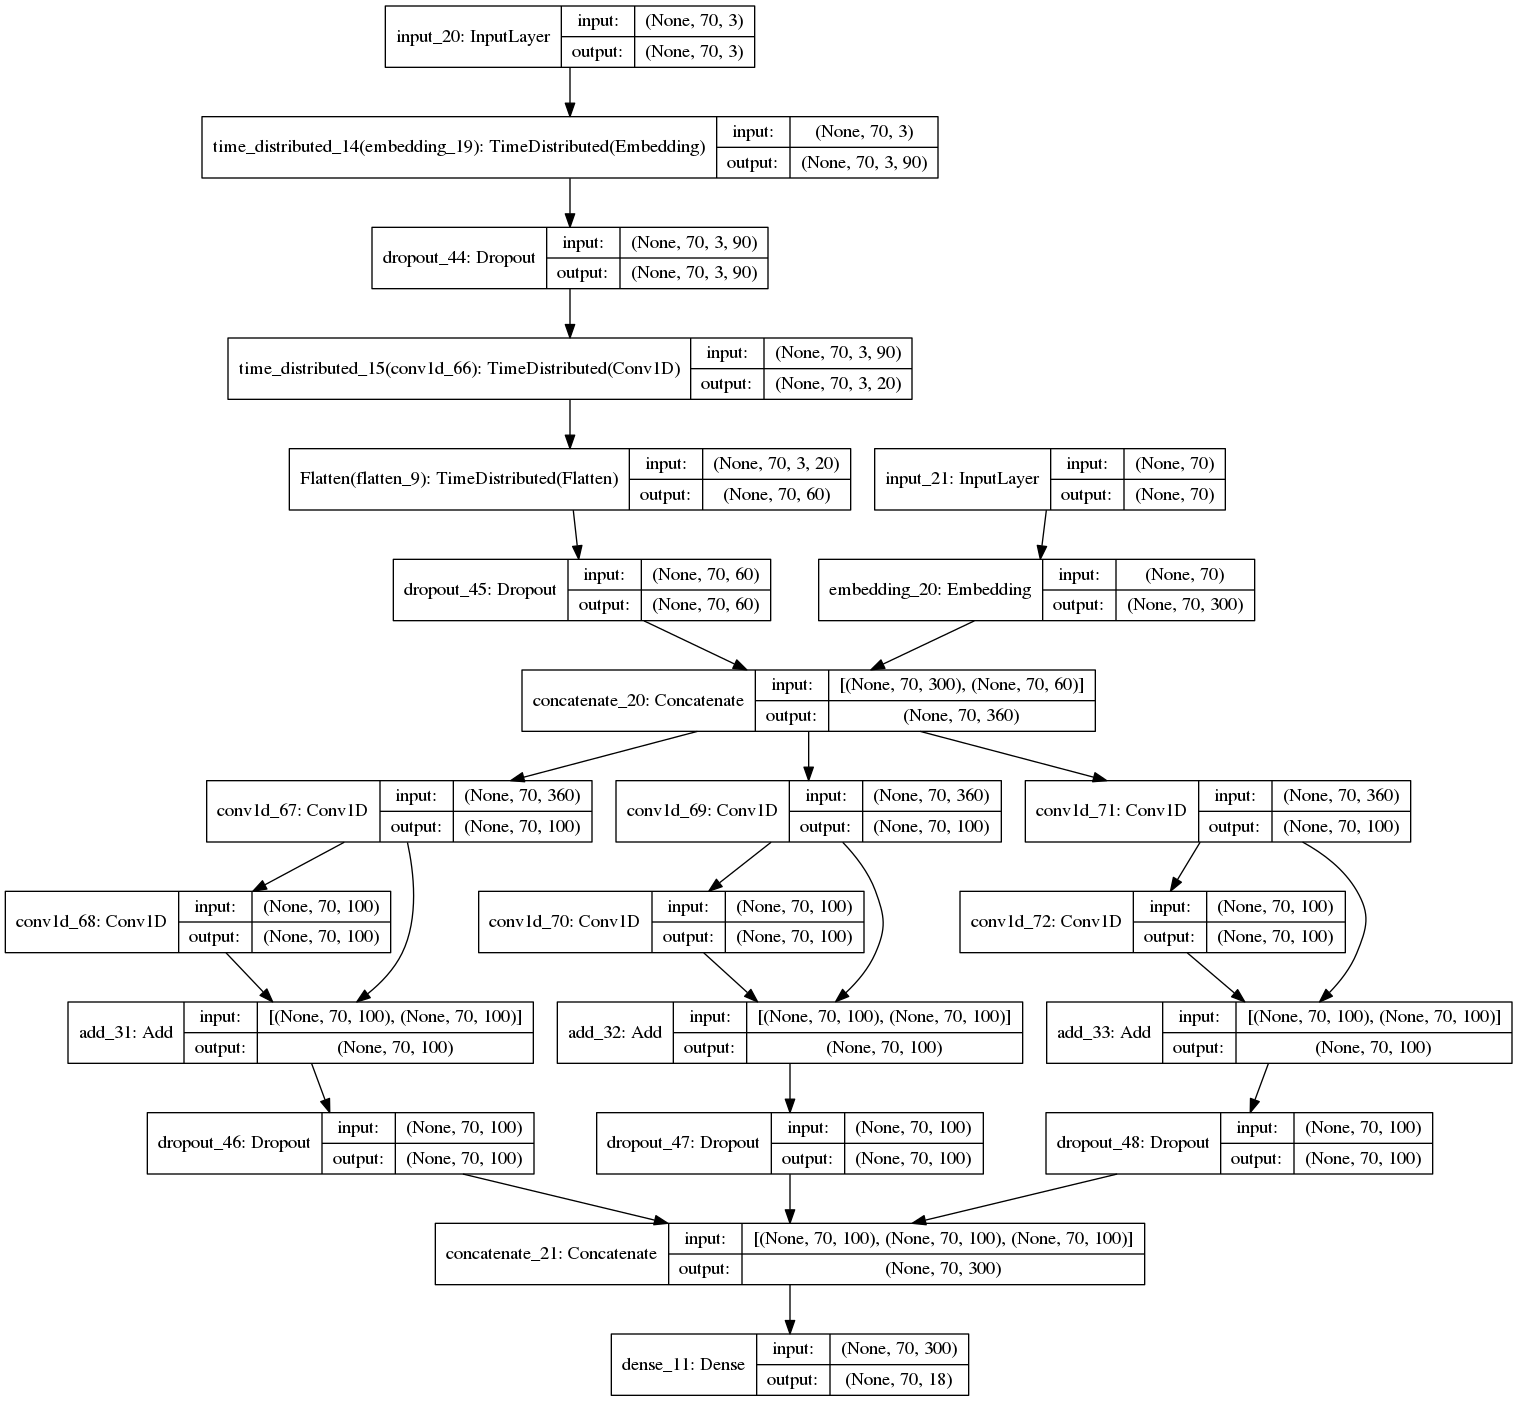

In [204]:
plot_model(model, to_file='model.png', show_shapes=True)
Image('model.png')

In [205]:
seed = 0
np.random.seed(seed)
t_ini = datetime.datetime.now()

cp = ModelCheckpoint(filepath="cnn_w2v_char_tagger.h5",
                     monitor='val_accuracy_masked',
                     save_best_only=True,
                     verbose=1)

early_stopping = EarlyStopping(monitor = 'val_accuracy_masked', patience = 5)


history = model.fit([X_train,
                     X_train_char_backward.reshape((len(X_train_char_backward), MAX_SEQUENCE_LENGTH, MAX_CHAR_LENGTH))
                    ],y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,          
                    validation_data=([X_test,
                                      X_test_char_backward.reshape((len(X_test_char_backward), MAX_SEQUENCE_LENGTH, MAX_CHAR_LENGTH))
                                     ],
                                     y_test),
                    verbose=1,
                    callbacks=[cp, early_stopping])

t_fin = datetime.datetime.now()
print('Training completed in {} seconds'.format((t_fin - t_ini).total_seconds()))

Train on 1952 samples, validate on 160 samples
Epoch 1/30
1952/1952 [==============================] - 3s 2ms/step - loss: 0.4429 - acc: 0.8770 - accuracy_masked: 0.6636 - val_loss: 0.0921 - val_acc: 0.9763 - val_accuracy_masked: 0.9215

Epoch 00001: val_accuracy_masked improved from -inf to 0.92151, saving model to cnn_w2v_char_tagger.h5
Epoch 2/30
1952/1952 [==============================] - 0s 219us/step - loss: 0.0765 - acc: 0.9798 - accuracy_masked: 0.9402 - val_loss: 0.0500 - val_acc: 0.9872 - val_accuracy_masked: 0.9565

Epoch 00002: val_accuracy_masked improved from 0.92151 to 0.95647, saving model to cnn_w2v_char_tagger.h5
Epoch 3/30
1952/1952 [==============================] - 0s 218us/step - loss: 0.0415 - acc: 0.9884 - accuracy_masked: 0.9658 - val_loss: 0.0472 - val_acc: 0.9882 - val_accuracy_masked: 0.9595

Epoch 00003: val_accuracy_masked improved from 0.95647 to 0.95952, saving model to cnn_w2v_char_tagger.h5
Epoch 4/30
1952/1952 [==============================] - 0s 25

## Classification report

In [206]:
from keras.models import load_model
model = load_model('cnn_w2v_char_tagger.h5', custom_objects={'accuracy_masked': accuracy_masked_class()})

In [207]:
y_pred = model.predict([X_test,
                        np.array(X_test_char_backward).reshape((len(X_test_char_backward), MAX_SEQUENCE_LENGTH, MAX_CHAR_LENGTH))
                       ], verbose=1).argmax(-1)
y_true = y_test.argmax(-1)

160/160 [==============================] - 1s 6ms/step


In [208]:
y_pred.shape

(160, 70)

In [209]:
y_true.shape

(160, 70)

In [210]:
# Function to convert label ids to labels and use them for sklearn's reports
def y2label(zipped, mask=0):
    out_true = []
    out_pred = []
    for zip_i in zipped:
        a, b = tuple(zip_i)
        if a != mask: #Exclude -PAD- term
            out_true.append(int2tag[a])
            out_pred.append(int2tag[b])
    return out_true, out_pred

In [211]:
y_zipped = zip(y_true.flat, y_pred.flat)
y_true, y_pred = y2label(y_zipped)

In [212]:
len(y_true), len(y_pred)

(3408, 3408)

In [213]:
name='CNN-Word embeddings+Character embeddings model'
print('\n---- Result of {} ----\n'.format(name))
print(classification_report(y_true, y_pred, digits=4))


---- Result of CNN-Word embeddings+Character embeddings model ----

              precision    recall  f1-score   support

         ADJ     0.8991    0.9152    0.9071       224
         ADP     0.9641    0.9898    0.9767       488
         ADV     0.9496    0.8626    0.9040       131
         AUX     0.9873    1.0000    0.9936       234
       CCONJ     1.0000    0.9896    0.9948        96
         DET     0.9955    0.9977    0.9966       439
        INTJ     0.0000    0.0000    0.0000         2
        NOUN     0.9695    0.9708    0.9701       753
         NUM     0.9839    1.0000    0.9919        61
        PART     0.9429    1.0000    0.9706        66
        PRON     0.9519    0.9340    0.9429       106
       PROPN     0.8824    0.8333    0.8571        90
       PUNCT     1.0000    1.0000    1.0000       339
       SCONJ     0.9286    0.7647    0.8387        51
        VERB     0.9485    0.9601    0.9543       326
           X     1.0000    1.0000    1.0000         2

   micro av

In [214]:
print("Accuracy: {0:.4f}".format(accuracy_score(y_true, y_pred)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_true, y_pred, average='macro')))

Accuracy: 0.9663
f1-macro score: 0.8936


## Confusion matrix

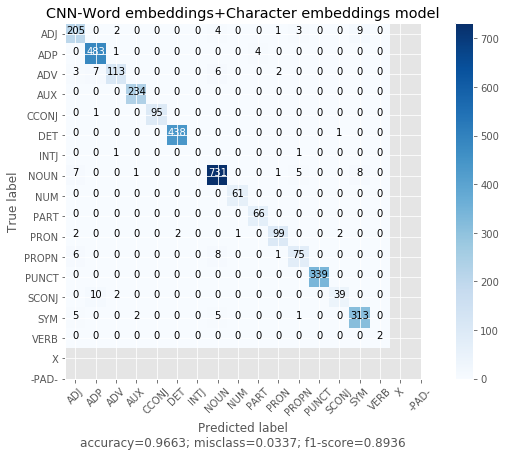

In [117]:
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(f1_score(y_true, y_pred, average='macro'), cnf_matrix, target_names=list(tag2int), title=name, normalize=False)

## Make a prediction for a test sample

In [118]:
y_pred = model.predict([X_test,
                        np.array(X_test_char_backward).reshape((len(X_test_char_backward), MAX_SEQUENCE_LENGTH, MAX_CHAR_LENGTH))], verbose=1).argmax(-1)
y_true = y_test.argmax(-1)

def make_prediction(i=10):
    note = ''
    sent = []
    print("{:15} ({:5}): {}".format("Word", "True", "Predicted"))
    print(35*'-')
    for w, true, pred in zip(X_test[i], y_true[i], y_pred[i]):
        if w!=0:
            if int2tag[true] != int2tag[pred]: note='<<--- Error!'
            print("{:15} ({:5}): {:5} {:5}".format(int2word[w], int2tag[true], int2tag[pred], note))
            note=''

160/160 [==============================] - 0s 65us/step


In [119]:
make_prediction(i=1)

Word            (True ): Predicted
-----------------------------------
any             (DET  ): DET        
use             (NOUN ): NOUN       
of              (ADP  ): ADP        
the             (DET  ): DET        
work            (NOUN ): NOUN       
other           (ADJ  ): ADJ        
than            (SCONJ): ADP   <<--- Error!
as              (ADP  ): ADP        
authorized      (VERB ): VERB       
under           (ADP  ): ADP        
this            (DET  ): DET        
license         (NOUN ): NOUN       
or              (CCONJ): CCONJ      
copyright       (NOUN ): NOUN       
law             (NOUN ): NOUN       
is              (AUX  ): AUX        
prohibited      (VERB ): VERB       
.               (PUNCT): PUNCT      


## Tag an unknown sentence

In [120]:
sentence = 'Word embeddings provide a dense representation of words and their relative meanings.'
sentence = nltk.word_tokenize(sentence.lower())

In [121]:
tokenized_sentence = []
unk = []
i=0
for word in sentence:
    if word in words:
        tokenized_sentence.append(word2int[word])
    else:
        tokenized_sentence.append(word2int['-UNK-'])
        i += 1
        unk.append(word)

#tokenized_sentence = [tokenized_sentence]
word_emb = pad_sequences([tokenized_sentence], maxlen=MAX_SEQUENCE_LENGTH, padding='post')

print('The sentence is:', sentence)
print('The tokenized sentence is:',tokenized_sentence)
print('The padded tokenized sentence is:', word_emb)
print("There are {:} unknown words in sentence: {:}".format(i,(unk)))

The sentence is: ['word', 'embeddings', 'provide', 'a', 'dense', 'representation', 'of', 'words', 'and', 'their', 'relative', 'meanings', '.']
The tokenized sentence is: [6784, 1, 4924, 267, 1, 5255, 4255, 6787, 540, 6203, 5193, 1, 19]
The padded tokenized sentence is: [[6784    1 4924  267    1 5255 4255 6787  540 6203 5193    1   19    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]]
There are 3 unknown words in sentence: ['embeddings', 'dense', 'meanings']


In [122]:
char_enc = char_numberize_backward([sentence], MAX_SEQUENCE_LENGTH, MAX_CHAR_LENGTH)
print('Character encodings has shape (1, MAX_SEQUENCE_LENGTH, MAX_CHAR_LENGTH) -->>',char_enc.shape)
predictions = model.predict([word_emb, char_enc])[0].argmax(-1)

print("\n{:25}| {:15}: {:15}".format("Word in embedding layer", 'Initial word', "Predicted POS-tag"))
print(61*'-')
k = 0
for i, pred in enumerate(predictions):
    try:
        if word_emb[0][i]!=0:
            print("{:25}| {:15}: {:5}".format(int2word[word_emb[0][i]], sentence[k], int2tag[pred]))
            k+=1
    except:
        pass

Character encodings has shape (1, MAX_SEQUENCE_LENGTH, MAX_CHAR_LENGTH) -->> (1, 70, 3)

Word in embedding layer  | Initial word   : Predicted POS-tag
-------------------------------------------------------------
word                     | word           : NOUN 
-UNK-                    | embeddings     : PRON 
provide                  | provide        : VERB 
a                        | a              : DET  
-UNK-                    | dense          : ADJ  
representation           | representation : NOUN 
of                       | of             : ADP  
words                    | words          : NOUN 
and                      | and            : CCONJ
their                    | their          : DET  
relative                 | relative       : ADJ  
-UNK-                    | meanings       : NOUN 
.                        | .              : PUNCT


Compare with result from (previous) CNN-Word embeddings model. Watch the **better prediction** for first word ('word'):

In [1]:
# Word in embedding layer  | Initial word   : Predicted POS-tag
# -------------------------------------------------------------
# word                     | word           : -PAD-
# -UNK-                    | embeddings     : PROPN
# provide                  | provide        : VERB 
# a                        | a              : DET  
# -UNK-                    | dense          : ADJ  
# representation           | representation : NOUN 
# of                       | of             : ADP  
# words                    | words          : NOUN 
# and                      | and            : CCONJ
# their                    | their          : DET  
# relative                 | relative       : ADJ  
# -UNK-                    | meanings       : NOUN 
# .                        | .              : PUNCT

## Frequent types of mistakes

In [123]:
def find_errors(X,y):
    support = 0
    error_counter = collections.Counter()
    y_pred = model.predict(X).argmax(-1)
    y_true = y_test.argmax(-1)
    for i in range(X[0].shape[0]):
        for w, true, pred in zip(X[0][i], y_true[i], y_pred[i]):
            if w!=0:
                if true != pred:
                    word = int2word[w]
                    error_counter[word] += 1
                support += 1 
    return error_counter, support

In [124]:
errors, support = find_errors([X_test,
                        np.array(X_test_char_backward).reshape((len(X_test_char_backward), MAX_SEQUENCE_LENGTH, MAX_CHAR_LENGTH))],y_test)
print('Total errors/Total words: {}/{} | Accuracy: {:.4}\n'.format(sum(errors.values()), support, 1-sum(errors.values())/support))
print('Most common errors:', errors.most_common(20))

Total errors/Total words: 115/3408 | Accuracy: 0.9663

Most common errors: [('as', 10), ('to', 5), ('appointed', 5), ('that', 3), ('part', 3), ('justice', 3), ('general', 3), ('is', 2), ('yes', 2), ('contracting', 2), ('romanian', 2), ('thereto', 2), ('longer', 2), ('base', 2), ('than', 1), ('express', 1), ('merchantibility', 1), ('noninfringement', 1), ('transit', 1), ('possible', 1)]


## Learning curves

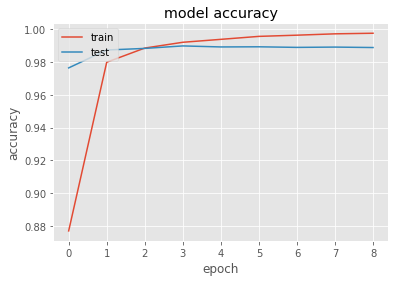

In [125]:
plot_acc()

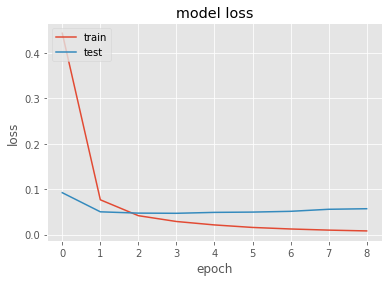

In [126]:
plot_loss()

 # =====================================================

# 3. CNN with ELMo embeddings + pre-trained word embeddings

In [127]:
import keras.backend as K
import tensorflow as tf
import tensorflow_hub as hub

W0527 20:14:55.193573 140575796942592 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


Elmo takes text as input, so we convert ids to words:

In [128]:
def denumberize(sentence):
    return np.asarray([(int2word[item]) for sublist in sentence for item in sublist]).reshape(sentence.shape[0],sentence.shape[1])
    

In [129]:
X_train_text= denumberize(X_train)
X_test_text = denumberize(X_test)

In [130]:
print('X_train_text shape', X_train_text.shape)
print('X_test_text shape', X_test_text.shape)
print('y_train shape', y_train.shape)
print('y_test shape', y_test.shape)

X_train_text shape (1952, 70)
X_test_text shape (160, 70)
y_train shape (1952, 70, 18)
y_test shape (160, 70, 18)


In [131]:
X_train_text[0:2]

array([['distribution', 'of', 'this', 'license', 'does', 'not', 'create',
        'an', 'attorney', '-', 'client', 'relationship', '.', '-PAD-',
        '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-',
        '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-',
        '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-',
        '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-',
        '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-',
        '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-',
        '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-',
        '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-'],
       ['creative', 'commons', 'provides', 'this', 'information', 'on',
        'an', '"', 'as', '-', 'is', '"', 'basis', '.', '-PAD-', '-PAD-',
        '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-',
        '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-',

In [132]:
del model

In [133]:
class ElmoEmbeddingLayer(keras.layers.Layer):
    def __init__(self, dimensions=1024, batch_size=BATCH_SIZE, seq_size=MAX_SEQUENCE_LENGTH, **kwargs):
        self.dimensions = 1024
        self.trainable = True
        self.batch_size = batch_size
        self.seq_size = seq_size
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable, 
                               name="{}_module".format(self.name)
                              )
        super().build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(inputs={
            "tokens": K.cast(x, tf.string),
            "sequence_len": K.constant(self.batch_size*[self.seq_size], dtype=tf.int32)
        },
            as_dict=True,
            signature='tokens',
        )['lstm_outputs1']
        return result

    def compute_mask(self, inputs, mask=None):
        return None

    def compute_output_shape(self, input_shape):
        return (None, self.seq_size, self.dimensions)

In [215]:
def define_model(length, filters, vocab_size):
    seed = 0
    
    np.random.seed(seed)
    inputs = Input(shape=(length, ), dtype='int32')
    np.random.seed(seed)
    word_emb = Embedding(input_dim=len(word2int),
                  output_dim=EMBEDDING_DIM,
                  weights=[embedding_matrix],
                  input_length=length,
                  trainable=True,
                  mask_zero=False
                 )(inputs)

    
    np.random.seed(seed)
    elmo_inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='string')
    # ELMo embeddings as weighted average across layers
    np.random.seed(seed)
    elmo_embeddings = ElmoEmbeddingLayer(batch_size=BATCH_SIZE, seq_size=MAX_SEQUENCE_LENGTH)(elmo_inputs)

    # Main CNN
    # Concatenate ELMO with Word embeddings
    np.random.seed(seed)
    embedding = concatenate([word_emb, elmo_embeddings])
    np.random.seed(seed)
    embedding = Dropout(0.5)(embedding)
    np.random.seed(seed)     
 
    # Channel 1
    np.random.seed(seed)
    channel_1 = Conv1D(filters=filters, kernel_size=2, padding='same')(embedding)
    #np.random.seed(seed)
    #channel_1 = add([embedding, channel_1])
    np.random.seed(seed)
    channel_1_2 = Conv1D(filters=filters, kernel_size=2, padding='same')(channel_1)
    #channel_1_3 = Conv1D(filters=filters, kernel_size=2, padding='same')(channel_1_2)
    np.random.seed(seed)
    channel_1 = add([channel_1, channel_1_2])
    np.random.seed(seed)
    channel_1 = Dropout(0.5)(channel_1) 

    # Channel 2
    np.random.seed(seed)
    channel_2 = Conv1D(filters=filters, kernel_size=3, padding='same')(embedding)
    np.random.seed(seed)
    #channel_2 = add([embedding, channel_2])
    #np.random.seed(seed)
    channel_2_2 = Conv1D(filters=filters, kernel_size=3, padding='same')(channel_2)
    #channel_2_3 = Conv1D(filters=filters, kernel_size=3, padding='same')(channel_2_2)
    np.random.seed(seed)
    channel_2 = add([channel_2, channel_2_2])
    np.random.seed(seed)
    channel_2 = Dropout(0.5)(channel_2)  

    # Channel 3
    np.random.seed(seed)
    channel_3 = Conv1D(filters=filters, kernel_size=4, padding='same')(embedding)
    np.random.seed(seed)
    #channel_3 = add([embedding, channel_3])
    #np.random.seed(seed)
    channel_3_2 = Conv1D(filters=filters, kernel_size=4, padding='same')(channel_3)
    #channe_3_3 = Conv1D(filters=filters, kernel_size=4, padding='same')(channel_3_2)
    np.random.seed(seed)
    channel_3 = add([channel_3, channel_3_2])
    np.random.seed(seed)
    channel_3 = Dropout(0.5)(channel_3) 

    np.random.seed(seed)    
    merged = concatenate([channel_1, channel_2, channel_3])
    np.random.seed(seed)    
    #merged = Dropout(0.2)(merged)
    
    np.random.seed(seed)
    output = Dense(n_tags, activation='softmax')(merged)  # softmax output layer   
    np.random.seed(seed)
    model = Model(inputs=[inputs, elmo_inputs], outputs=output)
    np.random.seed(seed)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', accuracy_masked_class(0)])
    print(model.summary())
    return model

In [216]:
model = define_model(length=MAX_SEQUENCE_LENGTH, filters=100, vocab_size=len(word2int))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 21:26:59.291080 140575796942592 saver.py:1483] Saver not created because there are no variables in the graph to restore


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 70)           0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 70, 300)      2055300     input_22[0][0]                   
__________________________________________________________________________________________________
elmo_embedding_layer_2 (ElmoEmb (None, 70, 1024)     0           input_23[0][0]                   
__________________________________________________________________________________________________
concatenat

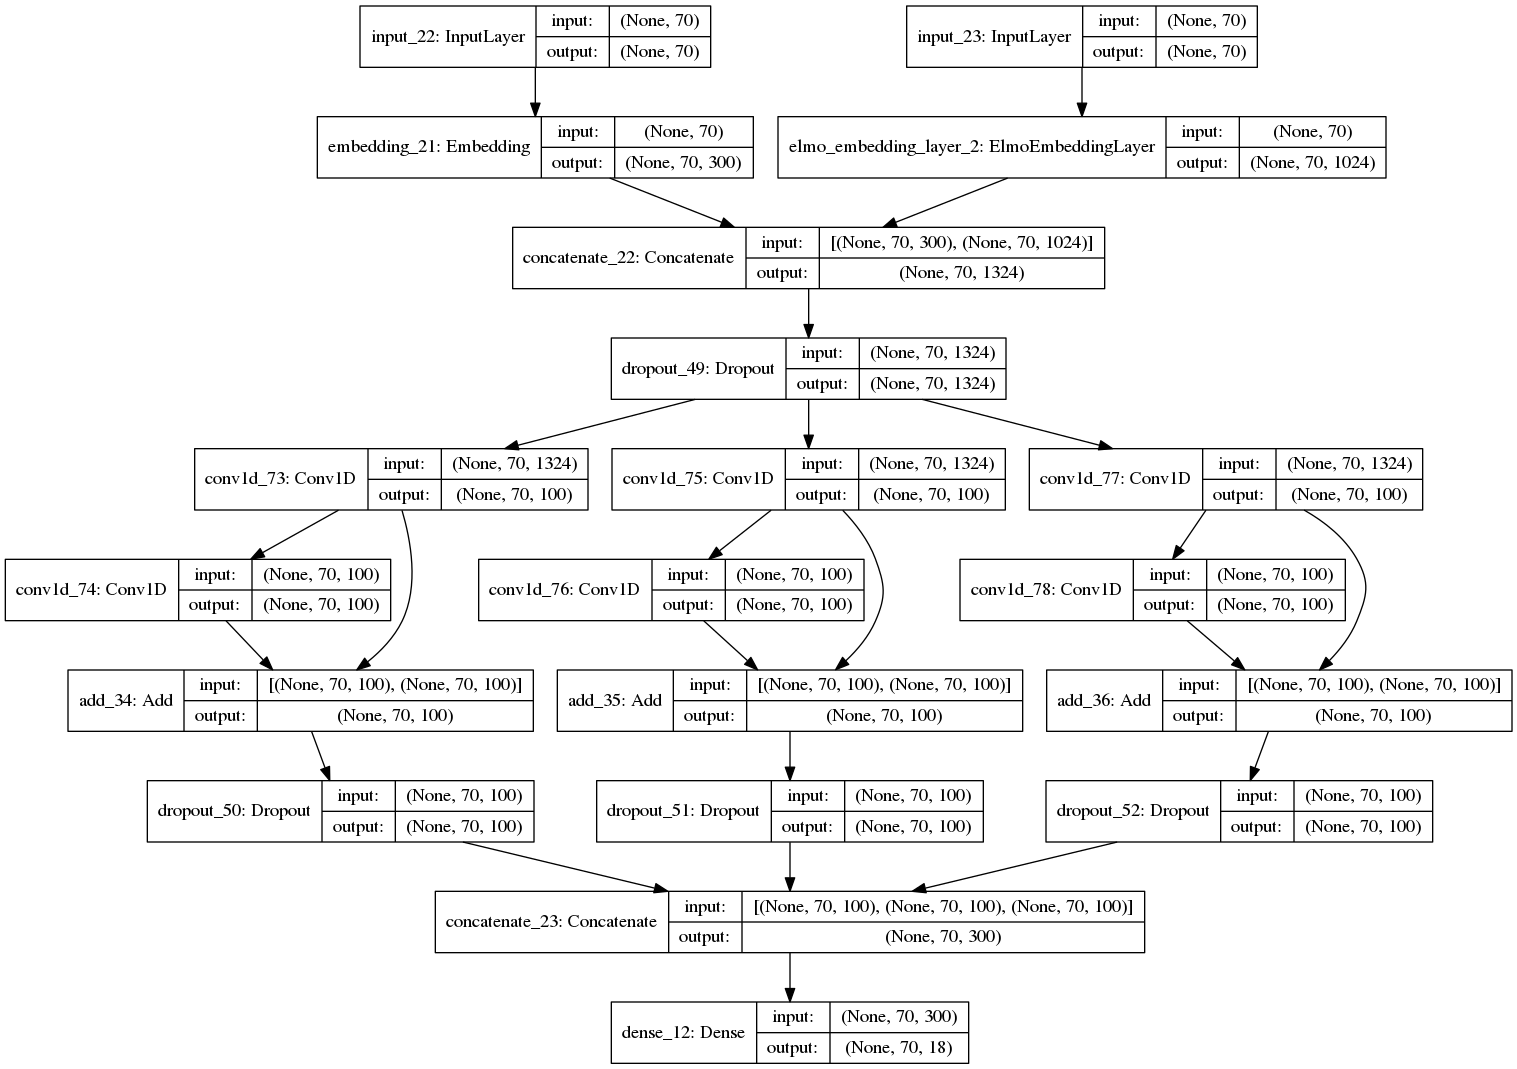

In [217]:
plot_model(model, to_file='model.png', show_shapes=True)
Image('model.png')

In [137]:
np.random.seed(seed)
t_ini = datetime.datetime.now()

cp = ModelCheckpoint(filepath="cnn_elmo_w2v_tagger.h5",
                     monitor='val_accuracy_masked',
                     save_best_only=True,
                     verbose=1)

early_stopping = EarlyStopping(monitor = 'val_accuracy_masked', patience = 5)


history = model.fit([X_train,
                     X_train_text], y_train, 
                    validation_data=([X_test,
                                      X_test_text], y_test),
                    #validation_split=0.1,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    verbose=1,
                    callbacks=[cp, early_stopping]) 

t_fin = datetime.datetime.now()
print('Training completed in {} seconds'.format((t_fin - t_ini).total_seconds()))

Train on 1952 samples, validate on 160 samples
Epoch 1/30
1952/1952 [==============================] - 13s 7ms/step - loss: 0.4781 - acc: 0.8980 - accuracy_masked: 0.7251 - val_loss: 0.0673 - val_acc: 0.9854 - val_accuracy_masked: 0.9520

Epoch 00001: val_accuracy_masked improved from -inf to 0.95201, saving model to cnn_elmo_w2v_tagger.h5
Epoch 2/30
1952/1952 [==============================] - 12s 6ms/step - loss: 0.0973 - acc: 0.9744 - accuracy_masked: 0.9241 - val_loss: 0.0544 - val_acc: 0.9879 - val_accuracy_masked: 0.9598

Epoch 00002: val_accuracy_masked improved from 0.95201 to 0.95978, saving model to cnn_elmo_w2v_tagger.h5
Epoch 3/30
1952/1952 [==============================] - 11s 6ms/step - loss: 0.0699 - acc: 0.9813 - accuracy_masked: 0.9447 - val_loss: 0.0514 - val_acc: 0.9890 - val_accuracy_masked: 0.9633

Epoch 00003: val_accuracy_masked improved from 0.95978 to 0.96331, saving model to cnn_elmo_w2v_tagger.h5
Epoch 4/30
1952/1952 [==============================] - 12s 6m

# Classification report

In [138]:
model = load_model('cnn_elmo_w2v_tagger.h5', custom_objects={'ElmoEmbeddingLayer': ElmoEmbeddingLayer, 'accuracy_masked': accuracy_masked_class()})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 20:19:40.496026 140575796942592 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [139]:
y_pred = model.predict([X_test,
                        X_test_text], batch_size=BATCH_SIZE).argmax(-1)
y_true = y_test.argmax(-1)

In [140]:
y_zipped = zip(y_true.flat, y_pred.flat)
y_true, y_pred = y2label(y_zipped)
len(y_true), len(y_pred)

(3408, 3408)

In [141]:
name='CNN-ELMo+Word embeddings model'
print('\n------------- Result of {} -------------\n'.format(name))
print(classification_report(y_true, y_pred, digits=4))


------------- Result of CNN-ELMo+Word embeddings model -------------

              precision    recall  f1-score   support

         ADJ     0.9043    0.9286    0.9163       224
         ADP     0.9699    0.9918    0.9807       488
         ADV     0.9600    0.9160    0.9375       131
         AUX     0.9915    0.9957    0.9936       234
       CCONJ     0.9896    0.9896    0.9896        96
         DET     1.0000    1.0000    1.0000       439
        INTJ     1.0000    1.0000    1.0000         2
        NOUN     0.9788    0.9788    0.9788       753
         NUM     0.9683    1.0000    0.9839        61
        PART     0.9565    1.0000    0.9778        66
        PRON     0.9810    0.9717    0.9763       106
       PROPN     0.9494    0.8333    0.8876        90
       PUNCT     1.0000    1.0000    1.0000       339
       SCONJ     0.9756    0.7843    0.8696        51
        VERB     0.9608    0.9785    0.9696       326
           X     1.0000    0.5000    0.6667         2

   micro 

In [142]:
print("Accuracy: {0:.4f}".format(accuracy_score(y_true, y_pred)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_true, y_pred, average='macro')))

Accuracy: 0.9748
f1-macro score: 0.9455


## Confusion matrix

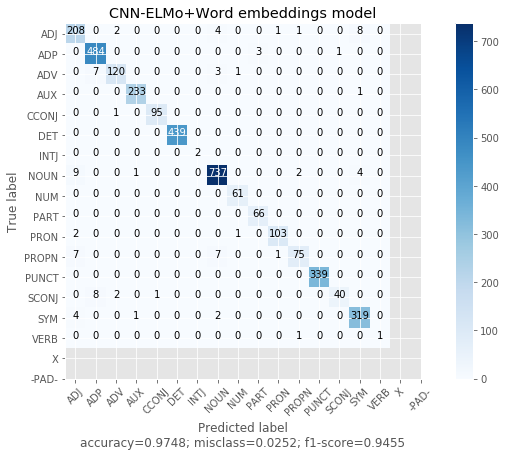

In [143]:
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(f1_score(y_true, y_pred, average='macro'), cnf_matrix, target_names=list(tag2int), title=name, normalize=False)

## Make a prediction for a test sample:

In [144]:
y_pred = model.predict([X_test,
                        #X_char_test_backward.reshape((len(X_char_test_backward), MAX_SEQUENCE_LENGTH, MAX_CHAR_LENGTH)),
                        X_test_text], batch_size=BATCH_SIZE).argmax(-1)
y_true = y_test.argmax(-1)

def make_prediction(i=16):
    note = ''
    sent = []
    print("{:15} ({:5}): {}".format("Word", "True", "Predicted"))
    print(35*'-')
    for w, true, pred in zip(X_test[i], y_true[i], y_pred[i]):
        if w!=0:
            if int2tag[true] != int2tag[pred]: note='<<--- Error!'
            print("{:15} ({:5}): {:5} {:5}".format(int2word[w], int2tag[true], int2tag[pred], note))
            note=''

In [145]:
make_prediction(i=1)

Word            (True ): Predicted
-----------------------------------
any             (DET  ): DET        
use             (NOUN ): NOUN       
of              (ADP  ): ADP        
the             (DET  ): DET        
work            (NOUN ): NOUN       
other           (ADJ  ): ADJ        
than            (SCONJ): ADP   <<--- Error!
as              (ADP  ): ADP        
authorized      (VERB ): VERB       
under           (ADP  ): ADP        
this            (DET  ): DET        
license         (NOUN ): NOUN       
or              (CCONJ): CCONJ      
copyright       (NOUN ): ADJ   <<--- Error!
law             (NOUN ): NOUN       
is              (AUX  ): AUX        
prohibited      (VERB ): VERB       
.               (PUNCT): PUNCT      


## Tag an unknown sentence

In [146]:
sentence = 'Word embeddings provide a dense representation of words and their relative meanings.'

In [147]:
sentence = nltk.word_tokenize(sentence.lower())

In [148]:
tokenized_sentence = []
unk = []
i=0
for word in sentence:
    if word in words:
        tokenized_sentence.append(word2int[word])
    else:
        tokenized_sentence.append(word2int['-UNK-'])
        i += 1
        unk.append(word)

#tokenized_sentence = [tokenized_sentence]
test_text = pad_sequences([tokenized_sentence], maxlen=MAX_SEQUENCE_LENGTH, padding='post')

print('The sentence is:', sentence)
print('The tokenized sentence is:',tokenized_sentence)
print('The padded tokenized sentence is:', test_text)
print("There are {:} unknown words in sentence: {:}".format(i,(unk)))

The sentence is: ['word', 'embeddings', 'provide', 'a', 'dense', 'representation', 'of', 'words', 'and', 'their', 'relative', 'meanings', '.']
The tokenized sentence is: [6784, 1, 4924, 267, 1, 5255, 4255, 6787, 540, 6203, 5193, 1, 19]
The padded tokenized sentence is: [[6784    1 4924  267    1 5255 4255 6787  540 6203 5193    1   19    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]]
There are 3 unknown words in sentence: ['embeddings', 'dense', 'meanings']


In [149]:
# Here we pad the single sentence representation until BATCH_SIZE, to make prediction work
word_emb = test_text.tolist()
word_emb.extend([[0]*MAX_SEQUENCE_LENGTH]*(BATCH_SIZE-1))
elmo_enc = denumberize(test_text).tolist()
elmo_enc.extend([[0]*MAX_SEQUENCE_LENGTH]*(BATCH_SIZE-1))

In [150]:
predictions = model.predict([word_emb, elmo_enc], batch_size=32)[0].argmax(-1)

print("\n{:25}| {:15}: {:15}".format("Word in embedding layer", 'Initial word', "Predicted POS-tag"))
print(61*'-')
k = 0
for i, pred in enumerate(predictions):
    try:
        if test_text[0][i]!=0:
            print("{:25}| {:15}: {:5}".format(int2word[test_text[0][i]], sentence[k], int2tag[pred]))
            k+=1
    except:
        pass


Word in embedding layer  | Initial word   : Predicted POS-tag
-------------------------------------------------------------
word                     | word           : NOUN 
-UNK-                    | embeddings     : NOUN 
provide                  | provide        : VERB 
a                        | a              : DET  
-UNK-                    | dense          : PUNCT
representation           | representation : NOUN 
of                       | of             : ADP  
words                    | words          : NOUN 
and                      | and            : CCONJ
their                    | their          : DET  
relative                 | relative       : ADJ  
-UNK-                    | meanings       : NOUN 
.                        | .              : PUNCT


Compare with result from CNN-Word embeddings model. Watch the **better predictions** for first two words ('word', 'embeddings'):

In [2]:
# Word in embedding layer  | Initial word   : Predicted POS-tag
# -------------------------------------------------------------
# word                     | word           : -PAD-
# -UNK-                    | embeddings     : PROPN
# provide                  | provide        : VERB 
# a                        | a              : DET  
# -UNK-                    | dense          : ADJ  
# representation           | representation : NOUN 
# of                       | of             : ADP  
# words                    | words          : NOUN 
# and                      | and            : CCONJ
# their                    | their          : DET  
# relative                 | relative       : ADJ  
# -UNK-                    | meanings       : NOUN 
# .                        | .              : PUNCT

## Frequent types of mistakes

In [151]:
def find_errors(X,y):
    error_counter = collections.Counter()
    support = 0
    y_pred = model.predict(X, batch_size=BATCH_SIZE).argmax(-1)
    y_true = y_test.argmax(-1)
    for i in range(X[0].shape[0]):
        for w, true, pred in zip(X[0][i], y_true[i], y_pred[i]):
            if int2word[w]!='-PAD-':
                if true != pred:
                    word = int2word[w]
                    error_counter[word] += 1
                support += 1
    return error_counter, support

In [152]:
errors, support = find_errors([X_test,
                      X_test_text],y_test)

In [153]:
print('Total errors/Total words: {}/{} | Accuracy: {:.4}\n'.format(sum(errors.values()), support, 1-sum(errors.values())/support))
print('Most common errors:', errors.most_common(20))

Total errors/Total words: 86/3408 | Accuracy: 0.9748

Most common errors: [('as', 8), ('appointed', 5), ('to', 4), ('part', 3), ('justice', 3), ('general', 3), ('than', 2), ('is', 2), ('contracting', 2), ('romanian', 2), ('where', 2), ('copyright', 1), ('express', 1), ('possible', 1), ('set', 1), ('interested', 1), ('traveling', 1), ('necessary', 1), ('at', 1), ('parties', 1)]


## Learning curves

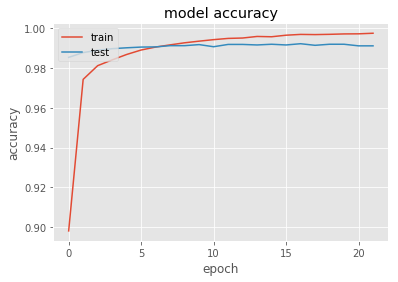

In [154]:
plot_acc()

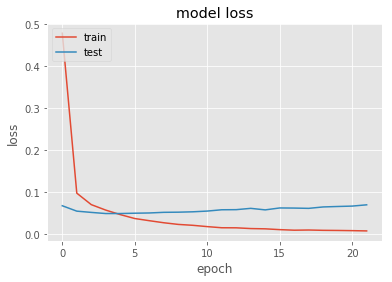

In [155]:
plot_loss()